# Predicting survival on the Titanic
<p><strong>Nam Nguyen</strong></p>
<p>Titanic, in full Royal Mail Ship (RMS) Titanic, British luxury passenger liner sank on in the early hours of April 15, 1912, during its maiden voyage, en route to New York City from Southampton, England. Of the 2,224 passengers and crew on board, 1,502 lost their lives in the disaster. Titanic has inspired countless books, articles and films (including the 1997 “Titanic” movie starring Kate Winslet and Leonardo DiCaprio), and the ship story has entered the public consciousness as one of the most famous tragedies in modern history.</p>
<p>In this notebook, we will look back Titanic disaster but in the eyes of data analysts to build a machine learning model that can predict if a passenger survived the sinking of the Titanic or not.</p>
<p><img src='titanic2.jpg' alt='Titanic disaster'></p>
<p>We'll use the <a href='https://www.kaggle.com/c/titanic/data'>Titanic dataset</a> from Kaggle for this notebook. The data dictionary is presented in following table:</p>

| Variables   |Definition | Key | Note |
| :-- | :-- | :-- | :-- |
| **survival** | Survival | 0 = No, 1 = Yes | |
| **sex** | Sex | | |
| **Age** | Age in years |   | Age is fractional if less than 1. <br/>If the age is estimated, is it in the form of xx.5 |
| **sibsp** | Number of siblings / <br/> spouses aboard the Titanic |   | Sibling = brother, sister, stepbrother, stepsister <br/>Spouse = husband, wife (mistresses and fiancés were ignored) |
| **parch** | Number of parents / <br/>children aboard the Titanic |   | Parent = mother, father <br/>Child = daughter, son, stepdaughter, stepson <br/> Some children travelled only with a nanny, therefore parch=0 for them |
| **ticket** | Ticket number | | |
| **fare** | Passenger fare | | |
| **cabin** | Cabin number | | |
| **embarked** | Port of Embarkation | C = Cherbourg<br/>Q = Queenstown<br/>S = Southampton | |

## Table of Contents
<ol>
    <li>Load and check data</li>
    <li>Data Cleaning</li>
    <li>Exploratory Data Analysis</li>
    <li>Feature engineering</li>
    <li>Converting data format</li>
    <li>Modeling</li>
    <li>Submission</li>
</ol>

## 1. Load and check data
<p>To begin, we import all of the modules, functions and objects we are going to use. Then, we load the data and take the look at the data to determine useful information:</p>
<ul>
    <li>Dimensions of the data.</li>
    <li>Types of data: which features are Categorial features, Numerical features</li>
    <li>Statistical summary of all features</li>
</ul>

In [1]:
#import libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style='whitegrid',palette='Set2')

In [3]:
# Load dataset and combine train and test set for visualization
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')
combined_data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

In [4]:
# Check the shape of combined dataset to know the dimensions of data
combined_data.shape

(1309, 12)

In [5]:
# View the first lines of dataset
combined_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<p> From our first glance at the data, we can see that the dataset have 1309 samples and 12 collumn including 11 features and our target variable, <code>Survived</code>. The dataset has a mixture of numerical and categorial features:</p>
<ul>
    <li><strong>Numerical Features</strong>: Age (Continuous), Fare (Continuous), SibSp (Discrete), Parch (Discrete)</li>
    <li><strong>Categorical Features</strong>: Survived (our target), Sex, Embarked, Pclass, Cabin, Ticket</li>
</ul>
<p> Another point we can see is we can extract information from feature <code>Name</code>, for example the relationship between passengers in family. However, this feature may contain errors or typos as there are many way to describe a name including titles, round brackets, and quotes. </p>
<p> In addition, feature <code>PassengerId</code> may not contribute to survival rate and can be dropped in later. While a new feature to group the members from the same family can be create from 2 features <code>Parch</code> and <code>SibSp</code>.</p>

In [6]:
# We take the first look at the information of our dataset
train_data.info()
print("-"*20)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    

<p>We can see features that have null values are <code>Age</code>, <code>Cabin</code>, <code>Fare</code> and <code>Embarked</code>. In these features, <code>Age</code>, <code>Fare</code> and <code>Embarked</code> should need to be completed as these features may correlate with Survival rate or other important features. While <code>Cabin</code> should be dropped from dataset because about 80% of this feature's values are missing.</p> 

## 2. Data Cleaning
<p>In this step, we are going to clean our data by:</p>
<ul>
    <li>Dropping unnescessary collumns</li>
    <li>Completing missing values </li>
    <li>Correcting aberrant values and outliers</li>
</ul>

In [7]:
# First, we drop unnecessary features that we determine above, those are Cabin and PassengerId
combined_data.drop(['Cabin','PassengerId'], axis=1, inplace=True)

<p> Then, we are going to complete the missing values in dataset. The basic method is using mean, median for numerical data and mode for categorial data. The more complex method is using basic method based on specific criteria, for example the missing values of <code>Age</code> can be filled by mean of <code>Age</code> by <code>PClass</code>. In the case of our dataset, we will fill the missing values of each feature as following:</p>
<ul>
    <li><code>Fare</code>: the median of group by <code>PClass</code>, <code>Parch</code> and <code>SibSp</code>. The <code>Fare</code> might be relate to the family size (<code>Parch</code> and <code>SibSp</code>) and <code>PClass</code> feature.</li>
    <li><code>Embarked</code>: the mode of whole data set.</li>
    <li><code>Age</code>: We also use median to fill the missing values of <code>Age</code>, but using the median of whole data set is not a good choice. The approach to feature <code>Age</code> is more complex. First,we create new feature named <code>Title</code> exacting from <code>Name</code> , and then, we fill the missing age for certain passager by the median of the <code>Title</code> this passenger has.</li>
</ul>

In [8]:
#First, we take a look at the only passerger who has missing value of Fare
combined_data[combined_data['Fare'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1043,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [9]:
#Then, we complete this missing value with the median Fare of 3rd class alone passenger 
combined_data['Fare']=combined_data['Fare'].fillna(combined_data.groupby(['Pclass','SibSp','Parch']).Fare.median()[3][0][0])

In [10]:
# Complete missing values in Embarked column with mode
combined_data['Embarked'].fillna(combined_data['Embarked'].mode()[0], inplace = True)

<p>Now, we are going to create new feature <code>Title</code> from <code>Name</code>. First, we take a look at <code>Name</code> to get its partern</p>

In [11]:
combined_data['Name'].sample(10)

743                                     McNamee, Mr. Neal
717                   Troutt, Miss. Edwina Celia "Winnie"
568                                   Doharr, Mr. Tannous
249                         Carter, Rev. Ernest Courtenay
97                        Greenfield, Mr. William Bertram
1238      Whabee, Mrs. George Joseph (Shawneene Abi-Saab)
427     Phillips, Miss. Kate Florence ("Mrs Kate Louis...
547                            Padro y Manent, Mr. Julian
1163        Clark, Mrs. Walter Miller (Virginia McDowell)
178                                    Hale, Mr. Reginald
Name: Name, dtype: object

<p>We can see the pattern of feature <code>Name</code> is:</p>
<p><em><strong>Last name, Title. First name</strong></em>. </p>
<p>Now we can exact the <code>Title</code> from <code>Name</code>. </p>

In [12]:
combined_data['Title'] = combined_data['Name'].str.split(', ', expand = True)[1].str.split('.', expand = True)[0]
combined_data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Jonkheer          1
Mme               1
Sir               1
Lady              1
the Countess      1
Capt              1
Don               1
Dona              1
Name: Title, dtype: int64

<p>From the list of above, we didive Title into 3 groups: <strong>Mr</strong>, <strong>Mrs</strong> and <strong>Master</strong>  </p>

In [13]:
common_title = ['Mr', 'Mrs', 'Master']
combined_data['Title'].replace(['Mlle','Ms','Mme', 'Miss', 'Lady', 'Dona', 'the Countess'],'Mrs', inplace=True)
combined_data['Title'].replace(['Sir', 'Rev', 'Capt', 'Don', 'Major', 'Col', 'Dr', 'Jonkheer'],'Mr', inplace=True)
# Check the Title we have
combined_data['Title'].value_counts()

Mr        783
Mrs       465
Master     61
Name: Title, dtype: int64

In [14]:
# Complete the missing value of Age
age_median_by_Title = combined_data.groupby('Title')['Age'].median()
for title in age_median_by_Title.index:
    combined_data['Age'][(combined_data.Age.isnull()) & (combined_data.Title == title)] = age_median_by_Title[title]

In [15]:
# We recheck to make sure we completed all of missing values
print('The data column with null value:\n', combined_data.isnull().sum())

The data column with null value:
 Survived    418
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
Title         0
dtype: int64


## 3. Exploratory Data Analysis
<p>We now have the basic idea about our dataset. In this step, we are going to extend that with some visualization. We will use both univariable plots to better understand each attribute and multivariate plots to show the realationship between each attribute and  survival rate</p>
<p>For Categorical features, we use count plot for each individual variable and bar plot for the relationship between this attribute and Survived. when it comes to numerical features, these plot are histogram and boxplot, respectively</p>

In [16]:
# Define function plotCategoricalFeatures to create 2 types of plot for each feature. 
def plotCategoricalFeatures(cat):
    fig, axes = plt.subplots(ncols=2,figsize=(20,6))
    sns.countplot(train_data[cat], ax=axes[0])
    sns.barplot(x=train_data[cat], y=train_data['Survived'], ax=axes[1])
    
    total = float(len(train_data[cat]))
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].text(p.get_x() + p.get_width() / 2., 
                     height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

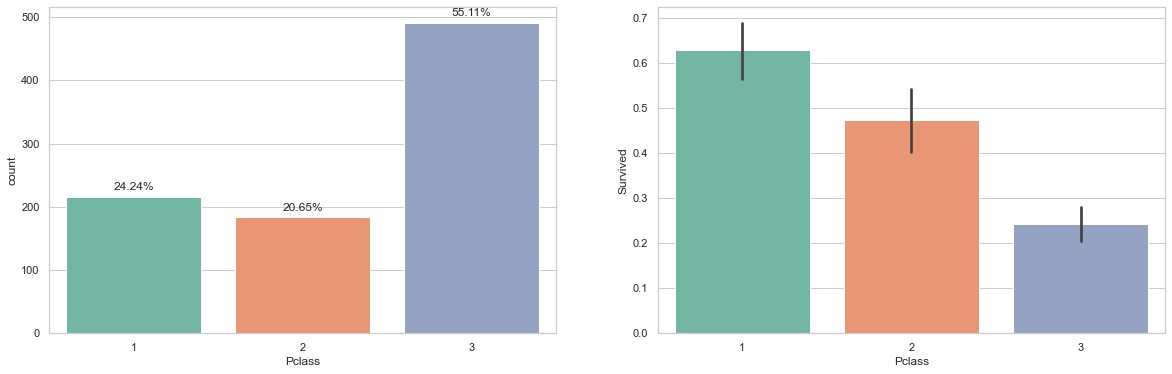

In [17]:
plotCategoricalFeatures('Pclass')

<p>The plots show that more than a half of passengers (54.11%) place in class 3 but the survival rate of class 1 is highest. This feature is the very helpful to our models.</p>

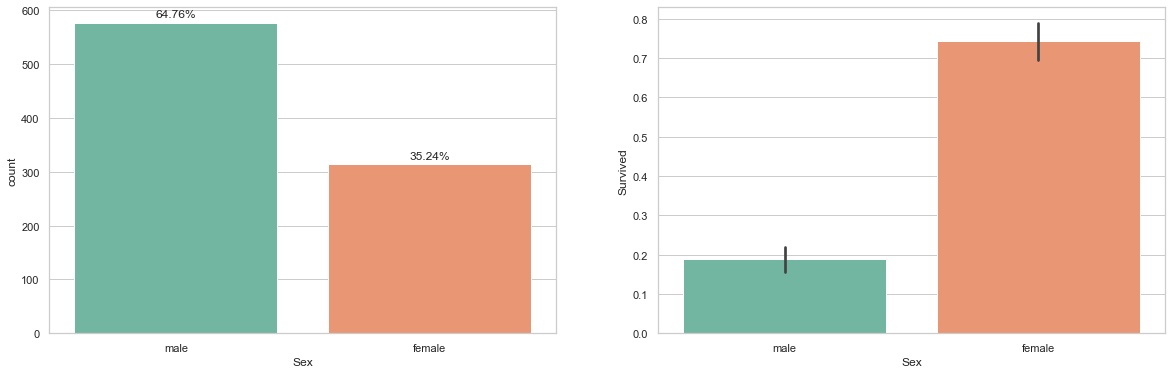

In [18]:
plotCategoricalFeatures('Sex')

<p>Feature <code>Sex</code> is one of the most useful feature for our models.</p>

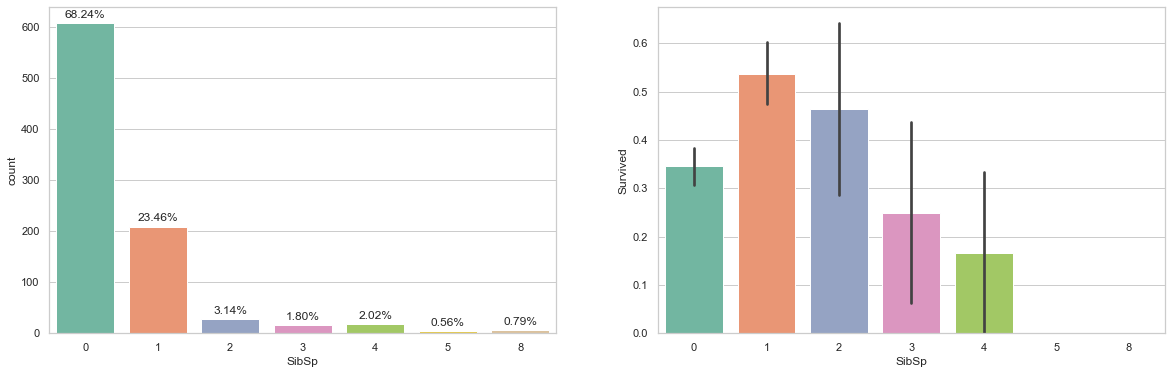

In [19]:
plotCategoricalFeatures('SibSp')

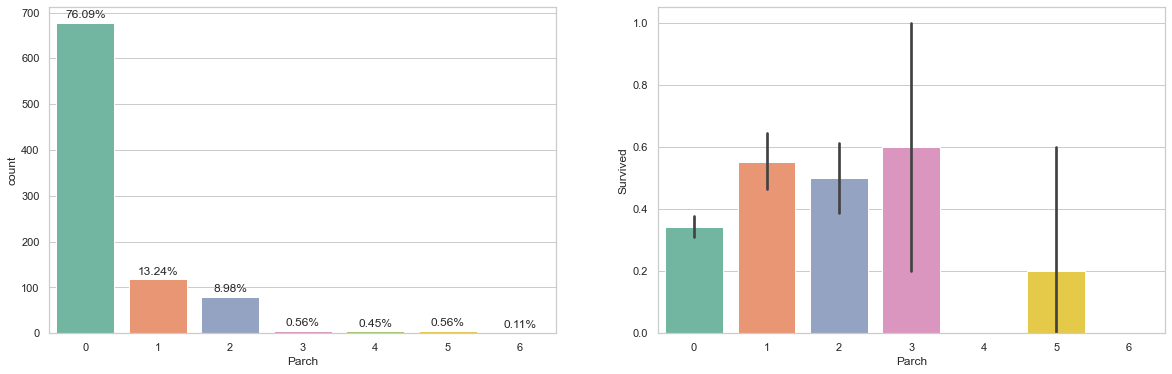

In [20]:
plotCategoricalFeatures('Parch')

<p>Parch and SibSp features show that passengers with only one family member has a higher survival rate</p>

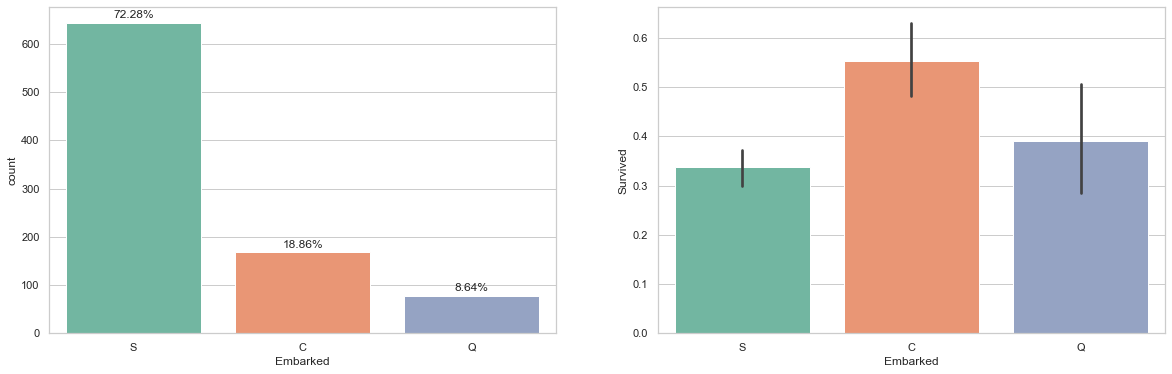

In [21]:
plotCategoricalFeatures('Embarked')

<p>Passengers boarded from <strong>Southampton</strong> has a lower survival rate unlike other ports. More than half of the passengers boarded from <strong>Cherbourg</strong> had survived</p>

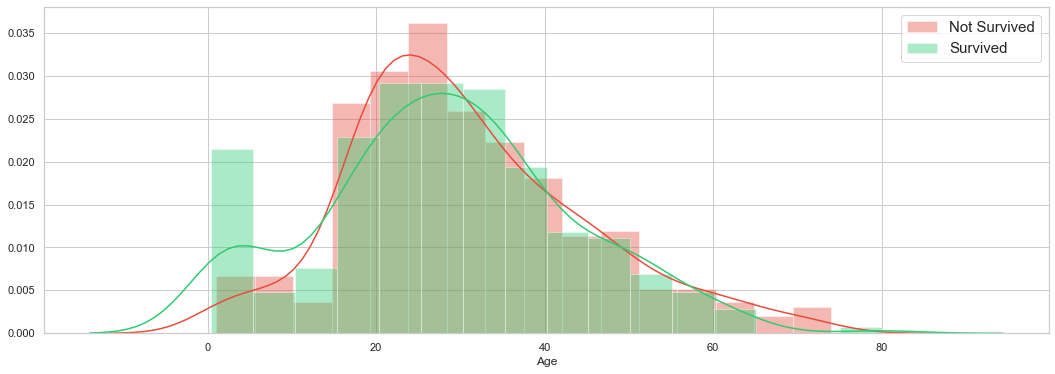

In [22]:
# Feature Age
fig, axs = plt.subplots(figsize=(18,6))
sns.distplot(train_data[~(train_data['Survived']==1)]['Age'], label='Not Survived', hist=True, color='#e74c3c')
sns.distplot(train_data[train_data['Survived']==1]['Age'], label='Survived', hist=True, color='#2ecc71')
axs.legend(loc='upper right', prop={'size': 15})

<p>The distribution of feature <code>Age</code> has a little right skewed with high number of young adults. Passengers are mainly from 20 to 40 years old and childern who are younger than 16 has a higher survival rate than other age groups</p>

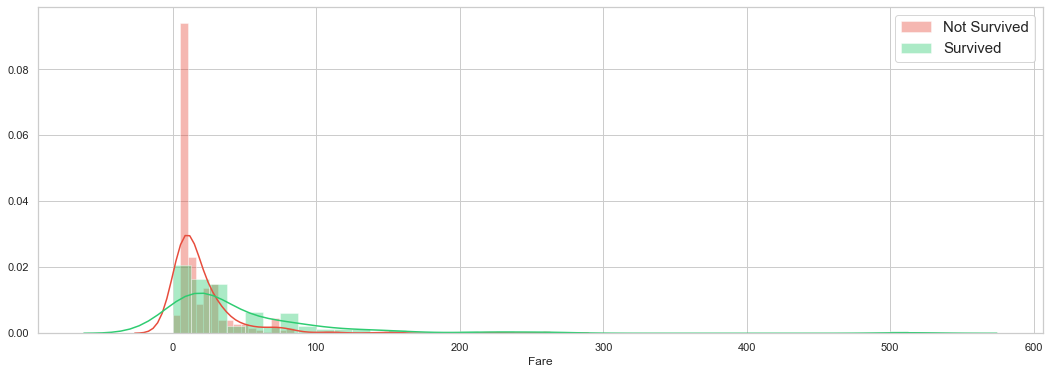

In [23]:
fig, axs = plt.subplots(figsize=(18,6))
sns.distplot(train_data[~(train_data['Survived']==1)]['Fare'], label='Not Survived', hist=True, color='#e74c3c')
sns.distplot(train_data[train_data['Survived']==1]['Fare'], label='Survived', hist=True, color='#2ecc71')
axs.legend(loc='upper right', prop={'size': 15})

<p>The distribution of feature <code>Fare</code> has positive skew because of the extremely large outliers. While most of the passenger fares are below 30, there are some outliers over 500. To get the better results, we might need to scale our data for the models or assigning bins.</p>

## 4. Feature engineering
<p>As we mentioned above, <code>SibSp</code> and <code>Parch</code> are both related to family members, therefore we can combine them into a new feature namely <code>FamilySize</code> to show how big the family a certain passenger belong to.</p>

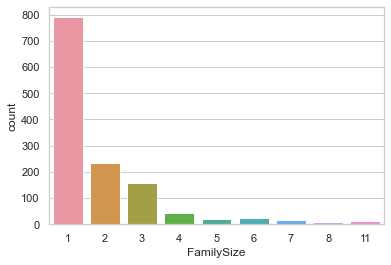

In [24]:
combined_data['FamilySize']=combined_data['SibSp'] + combined_data['Parch'] + 1
sns.countplot(combined_data['FamilySize'])

<p>Since being alone or <code>FamilySize= 1</code> is dominant in our data set, this feature might have an effect on survival. We are going to create new another feature for it, called <code>IsAlone</code>. This is a boolean feature which have value 1 for passengers travelling alone and 0 for the others.</p>

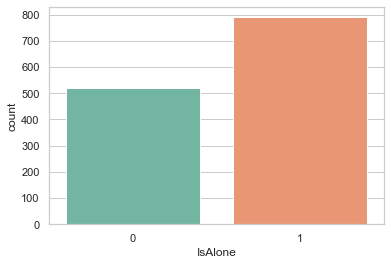

In [25]:
combined_data['IsAlone'] = combined_data['FamilySize'].map(lambda x: 1 if x==1 else 0)
sns.countplot(combined_data['IsAlone'])

In [26]:
combined_data.drop(['SibSp','Parch','FamilySize'], axis=1, inplace=True)

In [27]:
combined_data.sample(10)

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Title,IsAlone
1227,NaN,2,"de Brito, Mr. Jose Joaquim",male,32.0,244360,13.0000,S,Mr,1
493,0.0,1,"Artagaveytia, Mr. Ramon",male,71.0,PC 17609,49.5042,C,Mr,1
620,0.0,3,"Yasbeck, Mr. Antoni",male,27.0,2659,14.4542,C,Mr,0
689,1.0,1,"Madill, Miss. Georgette Alexandra",female,15.0,24160,211.3375,S,Mrs,0
194,1.0,1,"Brown, Mrs. James Joseph (Margaret Tobin)",female,44.0,PC 17610,27.7208,C,Mrs,1
1264,NaN,2,"Harbeck, Mr. William H",male,44.0,248746,13.0000,S,Mr,1
809,1.0,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,113806,53.1000,S,Mrs,0
1109,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,113503,211.5000,C,Mrs,0
1291,NaN,1,"Bonnell, Miss. Caroline",female,30.0,36928,164.8667,S,Mrs,1
149,0.0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,244310,13.0000,S,Mr,1


<p>The EDA process above suggest that women and children were prioritized in rescue. If we combine that to the assumption that the member in a family may survive or not together, we can go to the conclusion that in a family, women and children may survive or perish together, that mean we predict survival for women if her children survived and perished if her children perished, and vice versa.To do that, we firstly group members in a same family. Then, we are going to create a new feature to keep the survival rate affected by family factor.</p>
<p>In our features, <code>Surname</code> extracted from <code>Name</code> feature is probably the one can be used to group the family.</p>

In [28]:
combined_data['Surname'] = combined_data['Name'].str.split(',',expand=True)[0]

<p>However, using only <code>Surname</code> to group family may lead to the mistake. Let look at the passengers who have <code>Surname</code> are Brown</p>

In [29]:
combined_data.loc[combined_data['Surname']=='Brown',['Name','Surname','Ticket', 'Pclass', 'Embarked', 'Fare']]

,Name,Surname,Ticket,Pclass,Embarked,Fare
194,"Brown, Mrs. James Joseph (Margaret Tobin)",Brown,PC 17610,1,C,27.7208
345,"Brown, Miss. Amelia ""Mildred""",Brown,248733,2,S,13.0000
670,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",Brown,29750,2,S,39.0000
684,"Brown, Mr. Thomas William Solomon",Brown,29750,2,S,39.0000
1066,"Brown, Miss. Edith Eileen",Brown,29750,2,S,39.0000
1247,"Brown, Mrs. John Murray (Caroline Lane Lamson)",Brown,11769,1,S,51.4792


<p>The passengers 670, 684 and 1066 have the same Ticket, Pclass and Fare are certainly in same family. But passengers 194, 345 and 1247 have different values in these features, we can believe they not related. Therefore, we will create new stronger feature, namely <code>FamilyTicket</code>, to identify members in the same family. <code>FamilyTicket</code> is formed by <code>Surname, Ticket, Pclass, Fare</code> and <code>Embarked</code>.</p>

In [30]:
# Function getTickettoGroup(ticket) to preprocessing ticket to create FamilyTicket
def getTickettoGroup(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket[:-1]
    return ticket

combined_data['Ticketname'] = combined_data['Ticket'].map(getTickettoGroup)

# Now, combine Surname, Ticket, Pclass, Fare and Embarked to create new feature FamilyTicket
combined_data['FamilyTicket'] = combined_data['Surname'] + combined_data['Ticketname'] + \
                                combined_data['Pclass'].astype(str) + combined_data['Fare'].astype(str) + \
                                combined_data['Embarked']

<p>Next, we create feature<code>IsFamily</code> to mark if a certain passenger is alone or travel with family.</p>

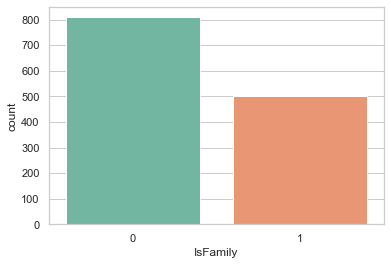

In [31]:
combined_data['IsFamily'] = combined_data['FamilyTicket'].duplicated(keep=False)*1
sns.countplot(combined_data['IsFamily'])

<p>Now we look at the feature FamilyTicket and IsFamily we have just created.</p>

In [32]:
combined_data[['Name', 'Age', 'Sex', 'FamilyTicket', 'IsFamily']].sort_values('FamilyTicket').head(10)

,Name,Age,Sex,FamilyTicket,IsFamily
845,"Abbing, Mr. Anthony",42.0,male,AbbingCA 55437.55S,0
1283,"Abbott, Master. Eugene Joseph",13.0,male,AbbottCA 267320.25S,1
746,"Abbott, Mr. Rossmore Edward",16.0,male,AbbottCA 267320.25S,1
279,"Abbott, Mrs. Stanton (Rosa Hunt)",35.0,female,AbbottCA 267320.25S,1
948,"Abelseth, Mr. Olaus Jorgensen",25.0,male,Abelseth3481237.65S,1
1236,"Abelseth, Miss. Karen Marie",16.0,female,Abelseth3481237.65S,1
874,"Abelson, Mrs. Samuel (Hannah Wizosky)",28.0,female,AbelsonPPP 338224.0C,1
308,"Abelson, Mr. Samuel",30.0,male,AbelsonPPP 338224.0C,1
1142,"Abrahamsson, Mr. Abraham August Johannes",20.0,male,AbrahamssonSOTONO2 31012837.925S,0
899,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,female,Abrahim26537.2292C,0


<p>Our feature <code>FamilyTicket</code> now look nice. We can see the Abbotts with Mrs Abbott and her son and daughter are grouped correctly. Next, we are going to identify families who have children and assign family ID for these familes. Passengers who are in a same family having children will have the same family ID.</p>

In [33]:
combined_data['isChild'] = combined_data.Age.map(lambda x: 1 if x<=16 else 0)
FamilyHavingChildren = combined_data[(combined_data['IsFamily']==1)&(combined_data['isChild']==1)]['FamilyTicket'].unique()
combined_data['FamilyID'] = 0
temp = 1
for family in FamilyHavingChildren:
    combined_data.loc[(combined_data['FamilyTicket'] == family), ['FamilyID']] = temp
    temp+=1

<p>Let check five family that have ID from 1 to 5</p>

In [34]:
combined_data[['Name', 'Age','Title','FamilyTicket', 'FamilyID', 'Survived']]\
[combined_data['FamilyID'].isin([1,2,3,4,5])].sort_values('FamilyID')

,Name,Age,Title,FamilyTicket,FamilyID,Survived
7,"Palsson, Master. Gosta Leonard",2.0,Master,Palsson34990321.075S,1,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",29.0,Mrs,Palsson34990321.075S,1,0.0
374,"Palsson, Miss. Stina Viola",3.0,Mrs,Palsson34990321.075S,1,0.0
24,"Palsson, Miss. Torborg Danira",8.0,Mrs,Palsson34990321.075S,1,0.0
1280,"Palsson, Master. Paul Folke",6.0,Master,Palsson34990321.075S,1,NaN
122,"Nasser, Mr. Nicholas",32.5,Mr,Nasser23773230.0708C,2,0.0
9,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,Mrs,Nasser23773230.0708C,2,1.0
1008,"Sandstrom, Miss. Beatrice Irene",1.0,Mrs,SandstromPP 954316.7S,3,NaN
10,"Sandstrom, Miss. Marguerite Rut",4.0,Mrs,SandstromPP 954316.7S,3,1.0
394,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",24.0,Mrs,SandstromPP 954316.7S,3,1.0


<p>Now we are going to visualize the ralationship among the members in a same familyby using stacked bar chart. in chart below, each bar is a family having children, we use <strong>green</strong> for passengers who survived, <strong>black</strong> for ones who did not and <strong>gray</strong> for passengers who we need to predict.</p>

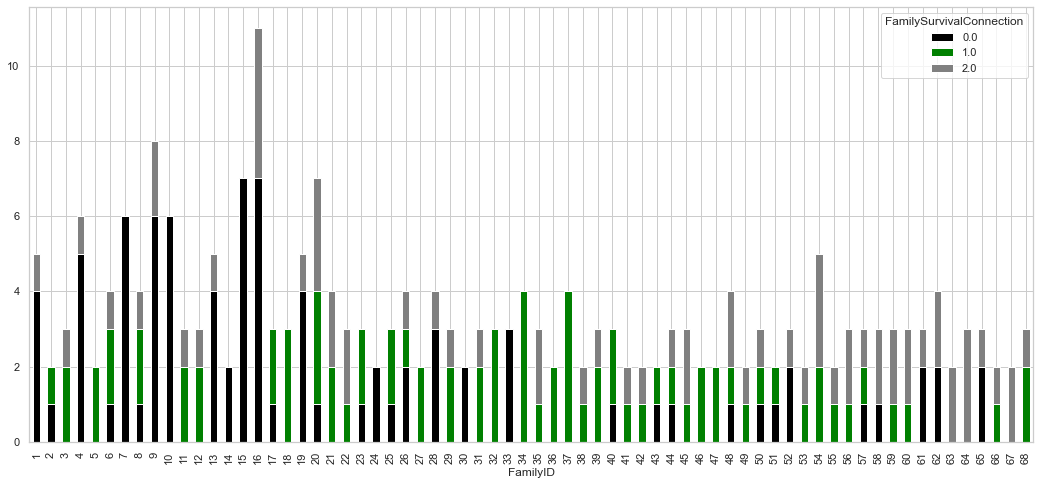

In [35]:
combined_data['FamilySurvivalConnection'] = combined_data['Survived'].fillna(2)
pd.crosstab(combined_data.FamilyID, 
            combined_data.FamilySurvivalConnection).drop([0]).plot(kind='bar',
                                                                   stacked=True, 
                                                                   color=['black', 'green', 'grey'], 
                                                                   figsize=(18, 8))

<p>We can see that most of families have only green or black instead of having both. That confirms our assumption that the members in a same family war likely to suvive or perish together. Now we are going to create a new feature to describe this property, we call this feature <code>FamilySurvival</code>. This feature has common value 0.5. But if a certain family had its all children or woman perish, this feature for all members is 0, otherwise it has value 1.</p>

In [36]:
combined_data['FamilySurvival'] = 0.5
combined_data['Survived']=combined_data['Survived'].fillna(0)
Survived_by_FamilyID = combined_data.groupby('FamilyID')
number_of_family = len(FamilyHavingChildren)
temp_rate = 0.5
for i in range(1,number_of_family + 1):
    temp_df = Survived_by_FamilyID.get_group(i)
    temp_rate = temp_df.loc[(temp_df.isChild == 1) | (temp_df.Title=='Mrs')]['Survived'].sum()
    if temp_rate == 0:
        combined_data.loc[(combined_data.FamilyID==i) & ((combined_data.Title == 'Mrs')|(combined_data.isChild ==1)), 
                          ['FamilySurvival']] = 0
    else:
        combined_data.loc[(combined_data.FamilyID==i) & ((combined_data.Title == 'Mrs')|(combined_data.isChild ==1)), 
                          ['FamilySurvival']] = 1

## 5. Converting data format

In [37]:
# Feature Transformation
combined_data['AgeBin'] = pd.qcut(combined_data['Age'], 5)
combined_data['FareBin'] = pd.qcut(combined_data['Fare'], 5)

label = LabelEncoder()
combined_data['AgeBin_Code'] = label.fit_transform(combined_data['AgeBin'])
combined_data['FareBin_Code'] = label.fit_transform(combined_data['FareBin'])
combined_data['Title_Code'] = combined_data['Title'].map({'Mr':0,'Mrs':1, 'Master':2}).astype('int')
combined_data['Sex_Code'] = combined_data['Sex'].map({'male':0, 'female':1}).astype('int')
combined_data['Embarked_Code'] = combined_data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')

In [38]:
combined_data.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare',
       'Embarked', 'Title', 'IsAlone', 'Surname', 'Ticketname',
       'FamilyTicket', 'IsFamily', 'isChild', 'FamilyID',
       'FamilySurvivalConnection', 'FamilySurvival', 'AgeBin', 'FareBin',
       'AgeBin_Code', 'FareBin_Code', 'Title_Code', 'Sex_Code',
       'Embarked_Code'], dtype=object)

In [39]:
combined_data.drop(['Survived', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 
                    'Embarked', 'Title', 'Surname', 'Ticketname', 'FamilyTicket',
                    'IsFamily', 'isChild', 'FamilyID', 'FamilySurvivalConnection',
                    'AgeBin', 'FareBin'], axis=1, inplace=True)

## 6. Modeling
### 6.1 Model Selection

In [40]:
y = train_data['Survived']
X = combined_data.iloc[:len(y)]
df_test = combined_data.iloc[len(y):]

In [41]:
print('X shape:', X.shape)
print('y shape:', y.shape)
print('df_test shape:', df_test.shape)
X.columns

X shape: (891, 8)
y shape: (891,)
df_test shape: (418, 8)


Index(['Pclass', 'IsAlone', 'FamilySurvival', 'AgeBin_Code', 'FareBin_Code',
       'Title_Code', 'Sex_Code', 'Embarked_Code'],
      dtype='object')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [43]:
models = [LogisticRegression(random_state=42),
         SVC(probability=True, random_state=42),
         DecisionTreeClassifier(random_state = 42),
         RandomForestClassifier(random_state = 42)]
models_columns = ['Name','Train Accuracy']
models_compare = pd.DataFrame(columns=models_columns)
temp = 0
for model in models:
    model_name = model.__class__.__name__
    models_compare.loc[temp,'Name'] = model_name
    model.fit(X_train, y_train)
    models_compare.loc[temp,'Train Accuracy'] = model.score(X_train, y_train)*100
    temp+=1
models_compare.sort_values(by = ['Train Accuracy'], ascending = False, inplace = True)
models_compare

,Name,Train Accuracy
2,DecisionTreeClassifier,89.6067
3,RandomForestClassifier,89.6067
0,LogisticRegression,85.5337
1,SVC,85.5337


In [44]:
models_columns = ['Name','Test Accuracy']
models_compare = pd.DataFrame(columns=models_columns)
temp = 0
for model in models:
    model_name = model.__class__.__name__
    models_compare.loc[temp,'Name'] = model_name
    test_accuracy = accuracy_score(y_test,model.predict(X_test))
#     cnf_matrix = confusion_matrix(y_test,model.predict(X_test))
    models_compare.loc[temp,'Test Accuracy'] = test_accuracy*100
    temp+=1
models_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
models_compare

,Name,Test Accuracy
3,RandomForestClassifier,85.4749
1,SVC,84.3575
2,DecisionTreeClassifier,84.3575
0,LogisticRegression,83.7989


<p>After conducting model selection, we dicided to perform our prediction with Random Forest. This model show the high score on both train and test set.</p>

### 6.2 Tune Model with Feature Selection

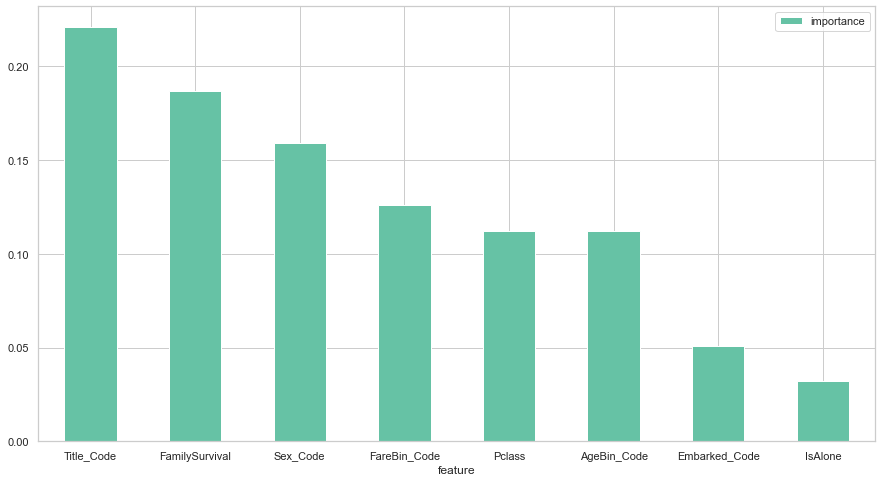

In [45]:
rfc = RandomForestClassifier(n_estimators = 200, random_state = 42)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature':X.columns, 'importance':np.round(rfc.feature_importances_,3)})
importance = importance.sort_values('importance', ascending=False).set_index('feature')
importance.plot(kind='bar', rot=0, figsize=(15,8))
plt.show()

In [46]:
features_selected = ['Title_Code','Sex_Code','FamilySurvival','FareBin_Code','Pclass']

### 6.3 Tune Model with Hyper-Parameters

In [47]:
grid_param = {'n_estimators':[100,200,300],
             'criterion':['gini','entropy'],
             'min_samples_split':[2,10,20],
             'min_samples_leaf':[1,5],
             'bootstrap':[True, False]}

grid_rfc = GridSearchCV(estimator = rfc,
                    param_grid = grid_param,
                    scoring = 'accuracy',
                    cv = 5,
                    n_jobs = -1)

grid_rfc.fit(X_train[features_selected], y_train)
rfc = grid_rfc.best_estimator_

In [48]:
all_accuracies = cross_val_score(estimator=rfc, X=X_train[features_selected], y=y_train, cv=5)
print(all_accuracies)
print('-'*10)
print(all_accuracies.mean())

[0.84615385 0.86013986 0.88028169 0.85211268 0.87323944]
----------
0.8623855018221216


## 7. Submission

In [49]:
df_test = df_test[features_selected]
rfc.fit(X_train[features_selected],y_train)
prediction = rfc.predict(df_test)
df_submission = pd.DataFrame({'PassengerId':test_data.PassengerId, 'Survived':prediction.astype(int)})
df_submission.to_csv('submission.csv', index=False)